In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
# from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
import cv2
from sklearn.cluster import DBSCAN
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

pose_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_pose/session_pose_info'
os.makedirs(pose_analysis_session_data,exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)


embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

In [2]:
session_filter_list = [
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

In [3]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]        
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [151]:
session_id = f'{session_filter_list[0]}-front'
case_study_input_cache_file = f"{case_study_input_data}/{session_id}.pb"
instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))


In [152]:
instructor_ids

array([11, 13, 15, 19, 21, 22, 23, 24, 27, 28, 30, 31, 34])

In [153]:
# get hand raises across all eligible ids
hand_positions = {'other':0, 'error':0, 'handsOnFace':0, 'armsCrossed':0, 'handsRaised':1}
posture_info.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 34])

In [154]:
posture_info[0].armPose.value_counts().index.values

array(['other', 'handsOnFace', 'armsCrossed', 'error', 'handsRaised'],
      dtype=object)

In [155]:
def frame_to_timestamp(frameNumber):
    return pd.to_timedelta(int(frameNumber*1000/15),unit='ms')
# frame_to_timestamp(70110)    

In [156]:


ts_data_dfs = []
sid_idx = 0
for sid in sorted(list(posture_info.keys())):
    if sid not in instructor_ids:
        handraise_sid = deepcopy(posture_info[sid]).reset_index()
        handraise_sid['time'] = handraise_sid['frame']//(60*15)
        handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
        handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
        handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
        handraise_sid['StudentID'] = sid_idx
        sid_idx+=1
        handraise_sid = handraise_sid[['StudentID','time','hand_raised']]
        ts_data_dfs.append(handraise_sid)

df_handraise = pd.concat(ts_data_dfs)
df_handraise.shape

(169, 3)

In [159]:
df_handraise.to_csv('CS_1A_single_session.csv',index=False)

/tmp/ipykernel_37368/2154862420.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([pd.to_datetime(tm*60, unit='s').strftime('%H:%M') for tm in ax.get_xticks()], fontsize=24)


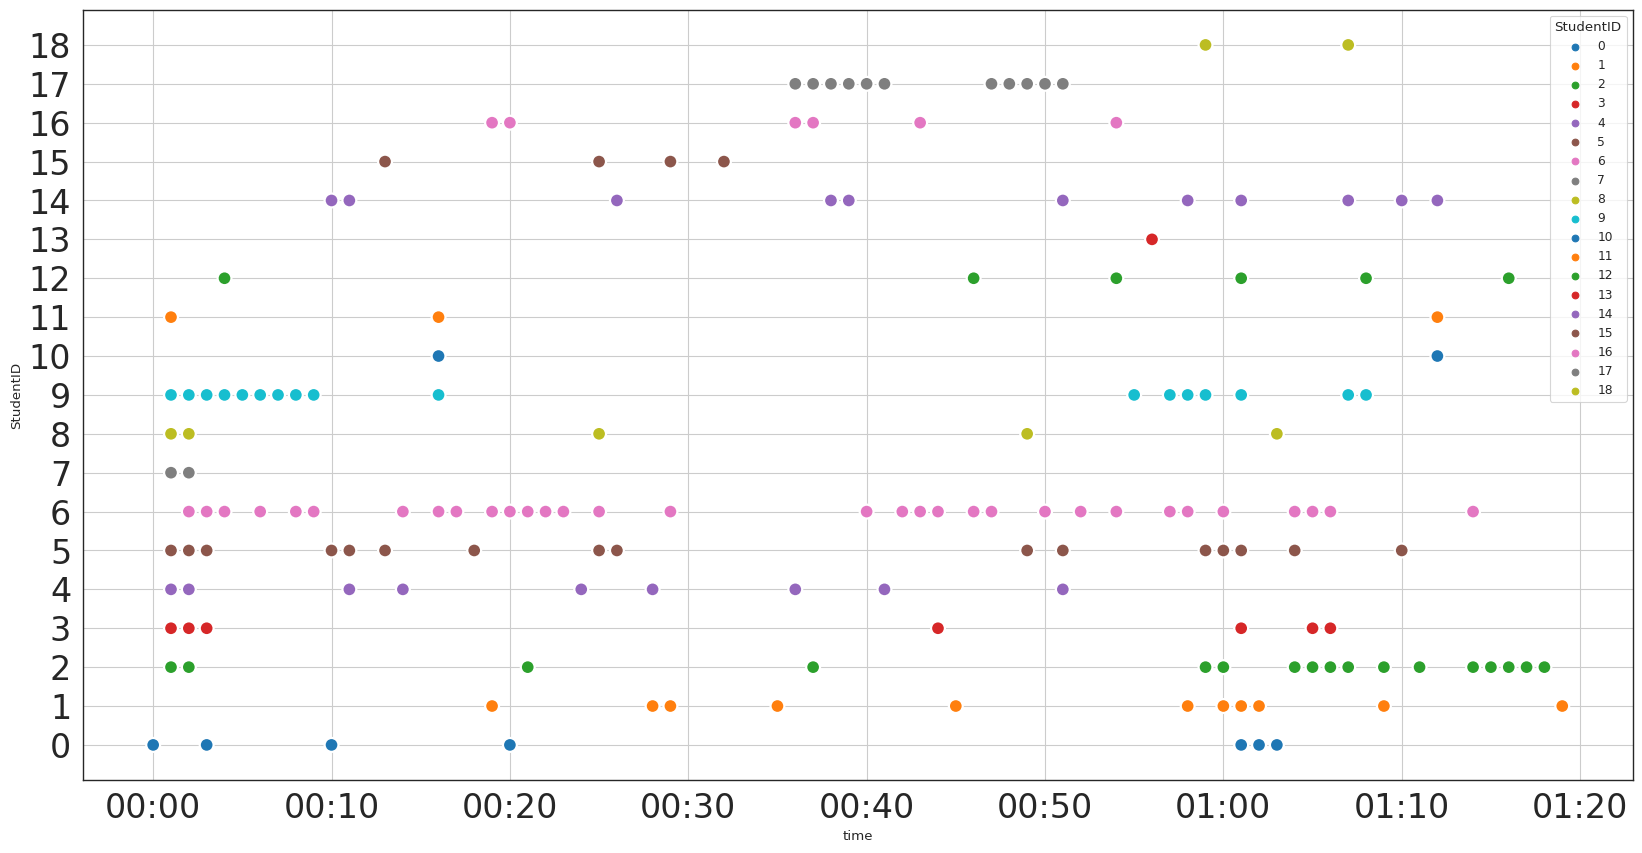

In [160]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(df_handraise, y='StudentID',x='time',hue='StudentID',palette='tab10',s=400,marker='.')
ax.set_xticklabels([pd.to_datetime(tm*60, unit='s').strftime('%H:%M') for tm in ax.get_xticks()], fontsize=24)
plt.yticks(range(sid_idx), range(sid_idx),fontsize=24)
plt.grid()

# Get Hand Raises and Unique Hand Raises across sessions

In [161]:
course='05748A'

total_session_data_dfs = []
for session in session_filter_list:
    if course not in session:
        continue
    session_id = f'{session}-front'
    case_study_input_cache_file = f"{case_study_input_data}/{session_id}.pb"
    instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))
    # get student id level hand raise for this session
    ts_data_dfs = []
    sid_idx = 0
    for sid in sorted(list(posture_info.keys())):
        if sid not in instructor_ids:
            handraise_sid = deepcopy(posture_info[sid]).reset_index()
            handraise_sid['time'] = handraise_sid['frame']//(60*15)
            handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
            handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
            handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
            handraise_sid['StudentID'] = sid_idx
            sid_idx+=1
            handraise_sid = handraise_sid[['StudentID','time']]
            ts_data_dfs.append(handraise_sid)
    
    df_handraise = pd.concat(ts_data_dfs)
    df_handraise = df_handraise.groupby('StudentID',as_index=False)['time'].count()
    df_handraise['session'] = session
    total_session_data_dfs.append(df_handraise)
df_session_hand_raises = pd.concat(total_session_data_dfs)
df_session_hand_raises

,StudentID,time,session
0,0,7,classinsight-cmu_05748A_ghc_4101_201902141630
1,1,11,classinsight-cmu_05748A_ghc_4101_201902141630
2,2,17,classinsight-cmu_05748A_ghc_4101_201902141630
3,3,7,classinsight-cmu_05748A_ghc_4101_201902141630
4,4,9,classinsight-cmu_05748A_ghc_4101_201902141630
...,...,...,...
12,14,5,classinsight-cmu_05748A_ghc_4101_201903071630
13,15,7,classinsight-cmu_05748A_ghc_4101_201903071630
14,16,1,classinsight-cmu_05748A_ghc_4101_201903071630
15,17,1,classinsight-cmu_05748A_ghc_4101_201903071630


In [163]:
df_session_hand_raises.to_csv('CS_1B_multiple_sessions.csv',index=False)

<Axes: xlabel='session'>

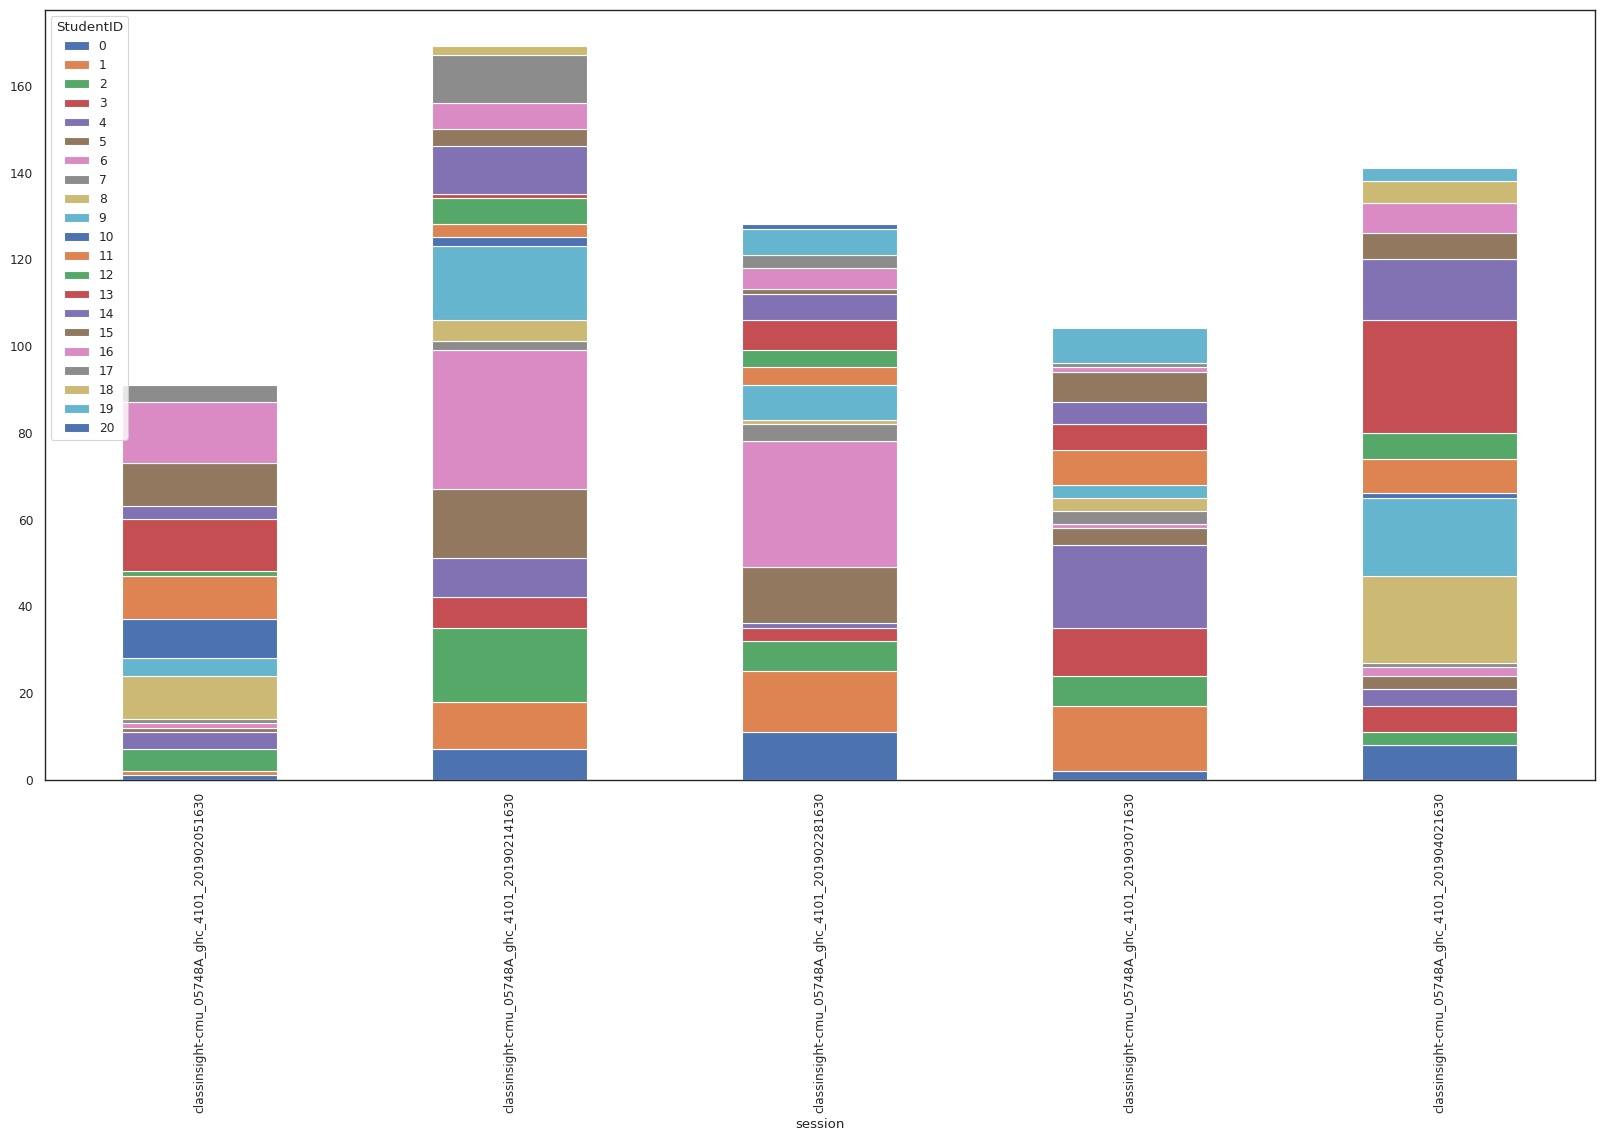

In [126]:
_, ax = plt.subplots(1,1,figsize=(20,10))
pd.pivot_table(df_session_hand_raises,index='session',columns='StudentID',values='time',aggfunc='mean').plot(kind='bar', stacked=True, ax=ax)

<Axes: xlabel='session', ylabel='time'>

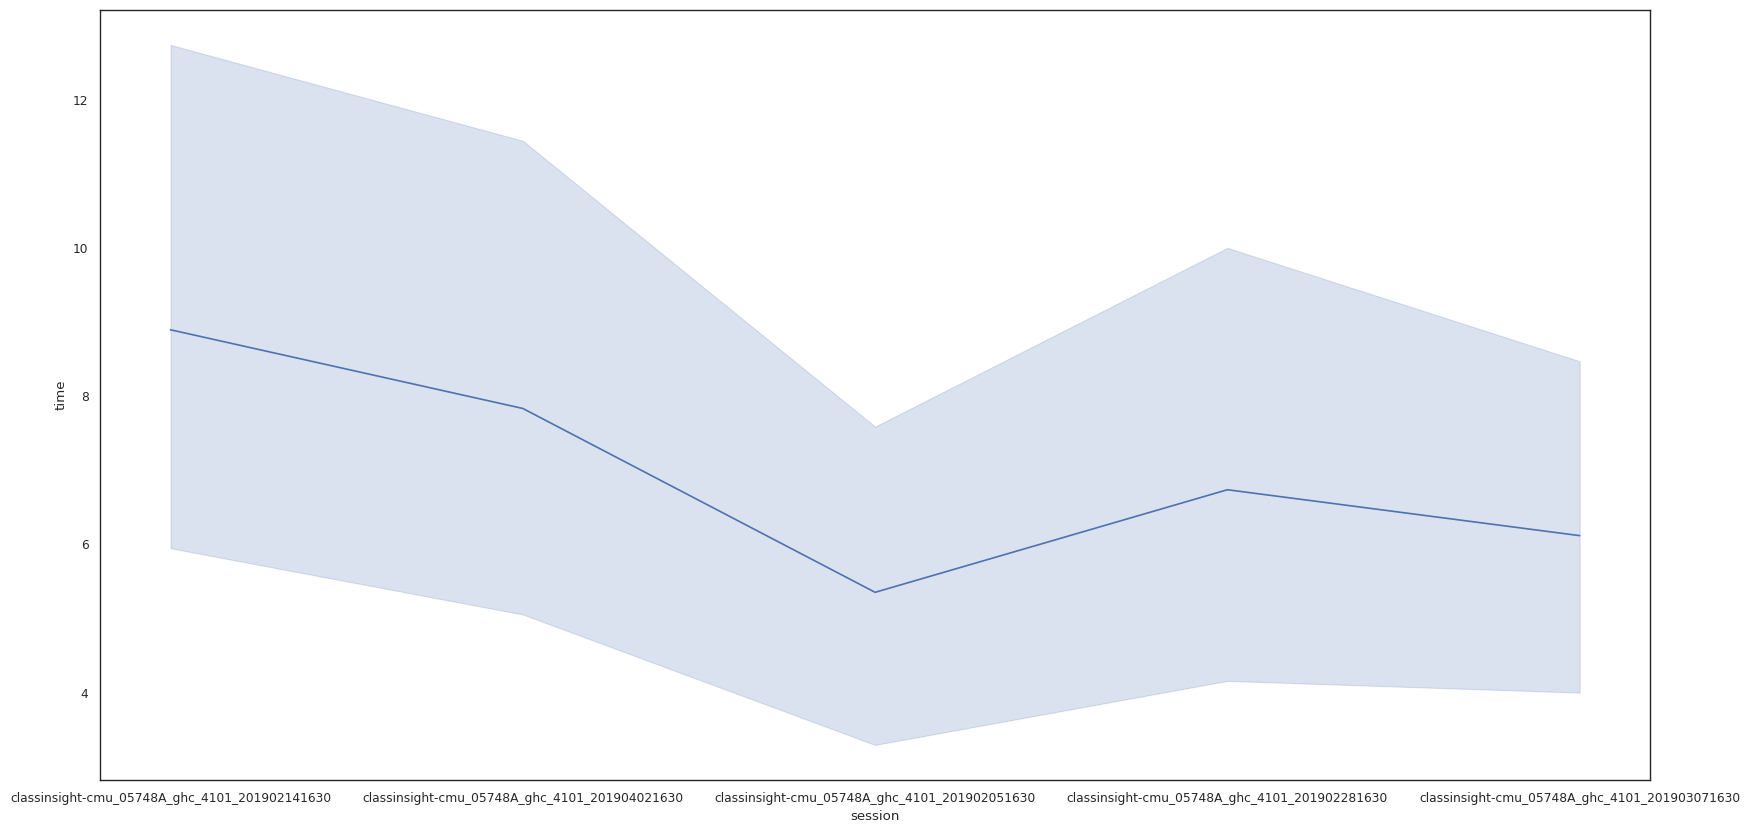

In [127]:
_, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(df_session_hand_raises, x='session',y='time')

# Across Student for 5 students 

In [140]:
across_session_pairs = {
     'classinsight-cmu_05748A_ghc_4101_201902051630':[9, 11],
     'classinsight-cmu_05748A_ghc_4101_201902141630':[9, 17],
     'classinsight-cmu_05748A_ghc_4101_201902281630':[1, 2 ],
     'classinsight-cmu_05748A_ghc_4101_201903071630':[3, 4],
     'classinsight-cmu_05748A_ghc_4101_201904021630':[3, 11],
}

In [141]:
course='05748A'

total_session_data_dfs = []
for session_idx, session in enumerate(across_session_pairs):
    session_id = f'{session}-front'
    case_study_input_cache_file = f"{case_study_input_data}/{session_id}.pb"
    instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))
    # get student id level hand raise for this session
    ts_data_dfs = []
    sid_idx = 0
    for sid in across_session_pairs[session]:
        if sid not in instructor_ids:
            handraise_sid = deepcopy(posture_info[sid]).reset_index()
            handraise_sid['time'] = handraise_sid['frame']//(60*15)
            handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
            handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
            handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
            handraise_sid['StudentID'] = sid_idx
            sid_idx+=1
            handraise_sid = handraise_sid[['StudentID','time']]
            ts_data_dfs.append(handraise_sid)
    
    df_handraise = pd.concat(ts_data_dfs)
    df_handraise = df_handraise.groupby('StudentID',as_index=False)['time'].count()
    df_handraise['session'] = session
    total_session_data_dfs.append(df_handraise)
df_session_hand_raises = pd.concat(total_session_data_dfs)
df_session_hand_raises

,StudentID,time,session
0,0,10,classinsight-cmu_05748A_ghc_4101_201902051630
1,1,9,classinsight-cmu_05748A_ghc_4101_201902051630
0,0,17,classinsight-cmu_05748A_ghc_4101_201902141630
1,1,11,classinsight-cmu_05748A_ghc_4101_201902141630
0,0,14,classinsight-cmu_05748A_ghc_4101_201902281630
1,1,7,classinsight-cmu_05748A_ghc_4101_201902281630
0,0,11,classinsight-cmu_05748A_ghc_4101_201903071630
1,1,19,classinsight-cmu_05748A_ghc_4101_201903071630
0,0,6,classinsight-cmu_05748A_ghc_4101_201904021630
1,1,8,classinsight-cmu_05748A_ghc_4101_201904021630


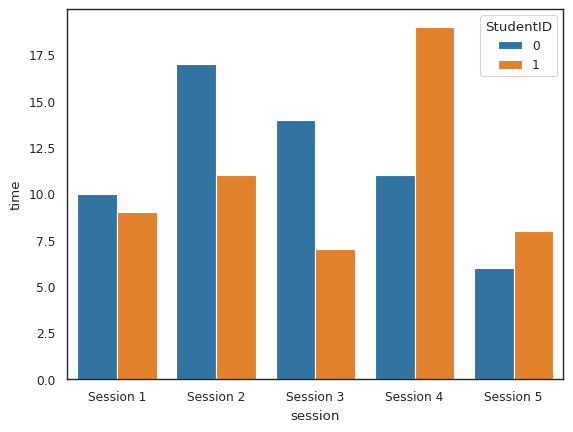

In [147]:
sns.barplot(df_session_hand_raises, x='session',y='time',hue='StudentID',palette='tab10')
_ = plt.xticks(range(5), [f'Session {i}' for i in range(1,6)])

In [149]:
# df_session_hand_raises.to_csv('CS_1C_across_session.csv',index=False)